# Modeling Multiband SOHO Photometry

In this tutorial we use a three-term Kronecker-structured covariance kernel to model multiband solar variability as observed by the SOHO spacecraft. We start off with some imports: 

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm
import theano.tensor as tt

from astropy.io import fits
from astropy.time import Time

import exoplanet as xo
from SpecGP.terms import KroneckerTerm
from SpecGP.distributions import MvUniform
from SpecGP.means import KroneckerConstant

%matplotlib inline

colors = ['#FE4365', '#3F9778', '#00A9FF', '#ECA25C', '#005D7F']

We're going to demonstrate SpecGP on data from the SOHO spacecraft's three-channel sunphotometer. The data we use is available at https://sohowww.nascom.nasa.gov/data/archive.html as three separate fits files. 

In [2]:
blue = fits.open('../../SpecGP/soho/blue.fits')
green = fits.open('../../SpecGP/soho/green.fits')
red = fits.open('../../SpecGP/soho/red.fits')
rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
i = 98765
n = 1000
t = t[i:i+n]
rgb = [f[i:i+n]/1e3 for f in rgb]

# add artificial white noise to the SOHO data in order 
# to make the model numerically stable.
rgb += np.random.randn(3, n) * np.exp(-4)

Let's plot the data and take a look at the power spectrum at each wavelength:

Text(0.025, 0.4, 'normalized flux')

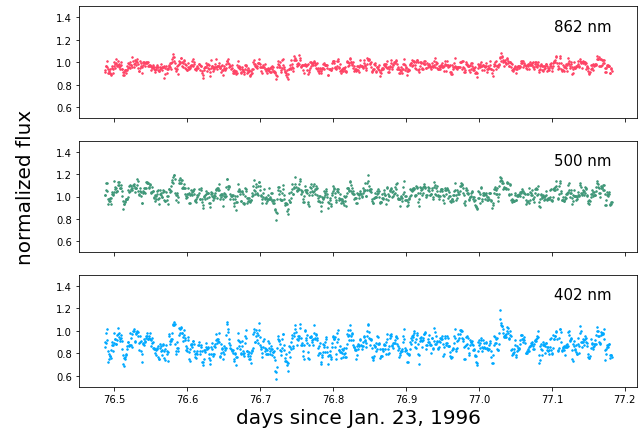

In [3]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
bands = ['862 nm', '500 nm', '402 nm']

[a.plot(t, 1+f, '.', color=colors[i], ms=3.0) for i, (a, f) in enumerate(zip(ax, rgb))]
[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
[ax.set_ylim(0.5, 1.5) for ax in ax]

ax[2].set_xlabel('days since Jan. 23, 1996', fontsize=20)
pl.annotate("normalized flux", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

Text(0.025, 0.4, 'power (ppm$^2$/Hz)')

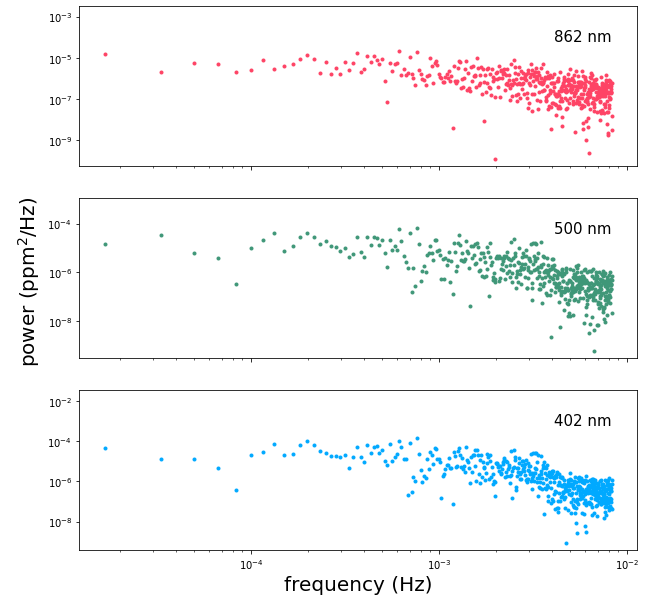

In [4]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])
f /= 60*60*24
fft = [np.fft.rfft(x) for x in rgb]
fft = [x*np.conj(x) for x in fft]
powerfft = [x.real / len(t)**2 for x in fft]

fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfft[0], '.', color=colors[0])
ax[1].loglog(f, powerfft[1], '.', color=colors[1])
ax[2].loglog(f, powerfft[2], '.', color=colors[2])

[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
ax[2].set_xlabel('frequency (Hz)', fontsize=20)
pl.annotate(r"power (ppm$^2$/Hz)", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

The shape of this power spectrum gives us an idea of how we should go about modeling the variability. Depending on the segment of the timeseries that we've chosen, we might observe a slight negative slope in the spectrum at the lowest frequencies, especially in the red band. This is due to trends in the timeseries on scales of days, probably due to rotationally modulated variability. The first term in our covariance kernel is meant to capture this part of the power spectrum. 

We see a slight break in the slope of the spectrum right around $10^{-3}$ Hz, possibly associated with the characteristic timescales of convective granulation on the Sun's surface. The second term in our covariance kernel is meant to capture that feature. 

Lastly, we observe a peak in the power at $0.003-0.004$ Hz possibly resulting from a superposition of asteroseismic modes. The third term in our covariance kernel is intended to model this feature. 

We use celerite's builtin ``SHOTerm`` to capture the time-correlation for each term in our kernel. For the first two terms we hold the ``log_Q`` parameter constant at a value of $-\mathrm{log}(\sqrt{2})$, corresponding to a critically-damped oscillator. The third term we allow to vary in order to model the observed peak in the spectrum which results from coherent oscillations in the Sun's brightness. 

This next cell is where we define and do inference on our model, so there's a lot to explain. Go ahead and run the code first, and we'll discuss the details afterwards. The last section of this cell runs the mcmc. It takes about 6 minutes on my computer, but feel free to comment that step out if you aren't ready to wait that long right now.

In [5]:
# construct the vector of observations 
y = np.vstack(rgb).T.reshape(3*len(t),)
    
with pm.Model() as model:
    
    logS0 = MvUniform("logS0", lower=[-20]*3, upper=[0.0]*3, testval=[-6, -15, -17])
    logw = MvUniform("logw", lower=[-3, 5, 7], upper=[1, 7, 10], testval=[-1, 6.5, 7.5])
    logQ = pm.Uniform("logQ", lower=0.0, upper=3.0, testval=1.5)
    alpha1 =  MvUniform("alpha1", lower=[0]*3, upper=[2]*3, testval=[0.5]*3)
    alpha2 =  MvUniform("alpha2", lower=[0]*3, upper=[2]*3, testval=[0.5]*3)
    mean = MvUniform("mean", lower=[-1]*3, upper=[1]*3, testval=tt.mean(rgb, axis=1))
    logsig = MvUniform("logsig", lower=[-15]*3, upper=[0.0]*3, testval=[-4]*3)
    
    term0 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[2],
        log_w0 = logw[2],
        log_Q = logQ
    )
        
    q0 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    q1 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
    q2 = tt.exp(tt.stack([0.0, alpha1[2], alpha2[2]]))
        
    kernel = (KroneckerTerm(term0, q0) + 
              KroneckerTerm(term1, q1) + 
              KroneckerTerm(term2, q2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=6, mean=KroneckerConstant(mean))
    gp.marginal("gp", observed = y)
        
    start = model.test_point
    map_soln = xo.optimize(start=start, verbose=True)
    start = map_soln
    
    # comment this out if you don't want to run the mcmc right now.
    trace = pm.sample(
        tune=500,
        draws=500,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

optimizing logp for variables: [logsig, mean, alpha2, alpha1, logQ, logw, logS0]


message: Desired error not necessarily achieved due to precision loss.
logp: 7401.518708508537 -> 8195.742175631714
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, mean, alpha2, alpha1, logQ, logw, logS0]
Sampling 2 chains, 890 divergences: 100%|██████████| 2000/2000 [06:03<00:00,  8.91draws/s]
There were 446 divergences after tuning. Increase `target_accept` or reparameterize.
There were 442 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The very first step in the code block above structures the input (observations) vector the way it needs to be for input to the Kronecker-structured GP. $y$ is a 1D vector with the first 3 elements consisting of the first observation at each of the 3 wavelengths, the next 3 being the second observation at each wavelength, and so forth. We could also write $y = vec(Y)$ where $Y$ is a matrix of size $3\times N$ with $N$ the number of times and with each of the three rows containing an entire timeseries observed at one wavelength.

The next important thing to notice comes when we define our probabilistic variables. We use the ``MvUniform`` distribution from ``SpecGP.distributions.MvUniform`` to define a uniform distribution for multiple variables. This distribution is provided purely as a convenience for organizing large numbers of parameters. For instance, we use the MvUniform distribution to define one ``log_S0`` variable that contains an element for each of our three celerite terms. We could just as easily have defined three separate univariate normal distributions. 

After defining our variables we construct the GP model in much the same way as for a 1D celerite model in exoplanet, the difference being that we wrap each celerite term in a ``KroneckerTerm`` which combines it with the $\alpha$ vector that defines the covariance for the wavelength dimension. 

The final important thing to note is that we must specify a mean consistent with the Kronecker-structured kernel function. For this purpose we provide the ``KroneckerConstant`` mean which takes as its single argument an array of (in this case) 3 constant mean values, one for each wavelength.

Now let's take a look at the psd of the maximum-likelihood solution (as found via ``xo.optimize`` above, which wraps ``scipy.optimize.minimize``):  

Text(0.025, 0.4, 'power (ppm$^2$/Hz)')

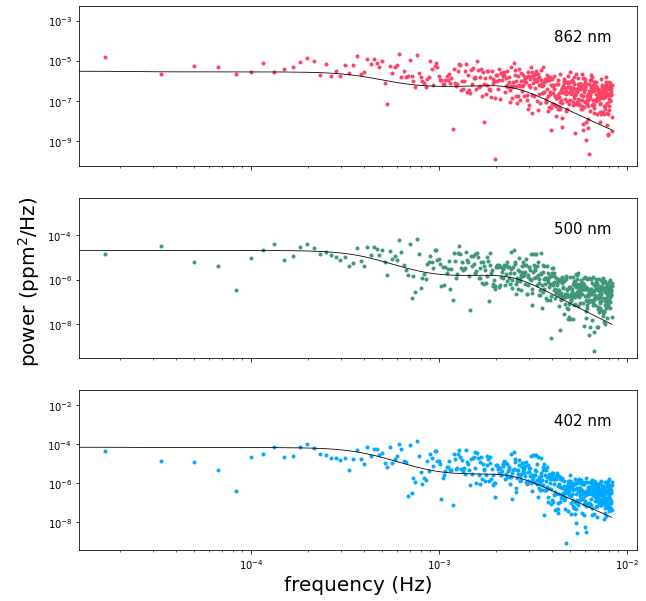

In [6]:
fdays = f * 60*60*24
with model:
    psd = xo.eval_in_model(
        kernel.psd(2*np.pi*fdays), map_soln)
    
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfft[0], '.', color=colors[0])
ax[1].loglog(f, powerfft[1], '.', color=colors[1])
ax[2].loglog(f, powerfft[2], '.', color=colors[2])

ax[0].loglog(f, psd.T[0], color='k', linewidth=0.8)
ax[1].loglog(f, psd.T[1], color='k', linewidth=0.8)
ax[2].loglog(f, psd.T[2], color='k', linewidth=0.8)

[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
ax[2].set_xlabel('frequency (Hz)', fontsize=20)
pl.annotate(r"power (ppm$^2$/Hz)", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

A straightforward optimization doesn't always give us the best solution for the system, but sometimes it does alright. If you ran MCMC above, then you can also examine the corner plot for the system:

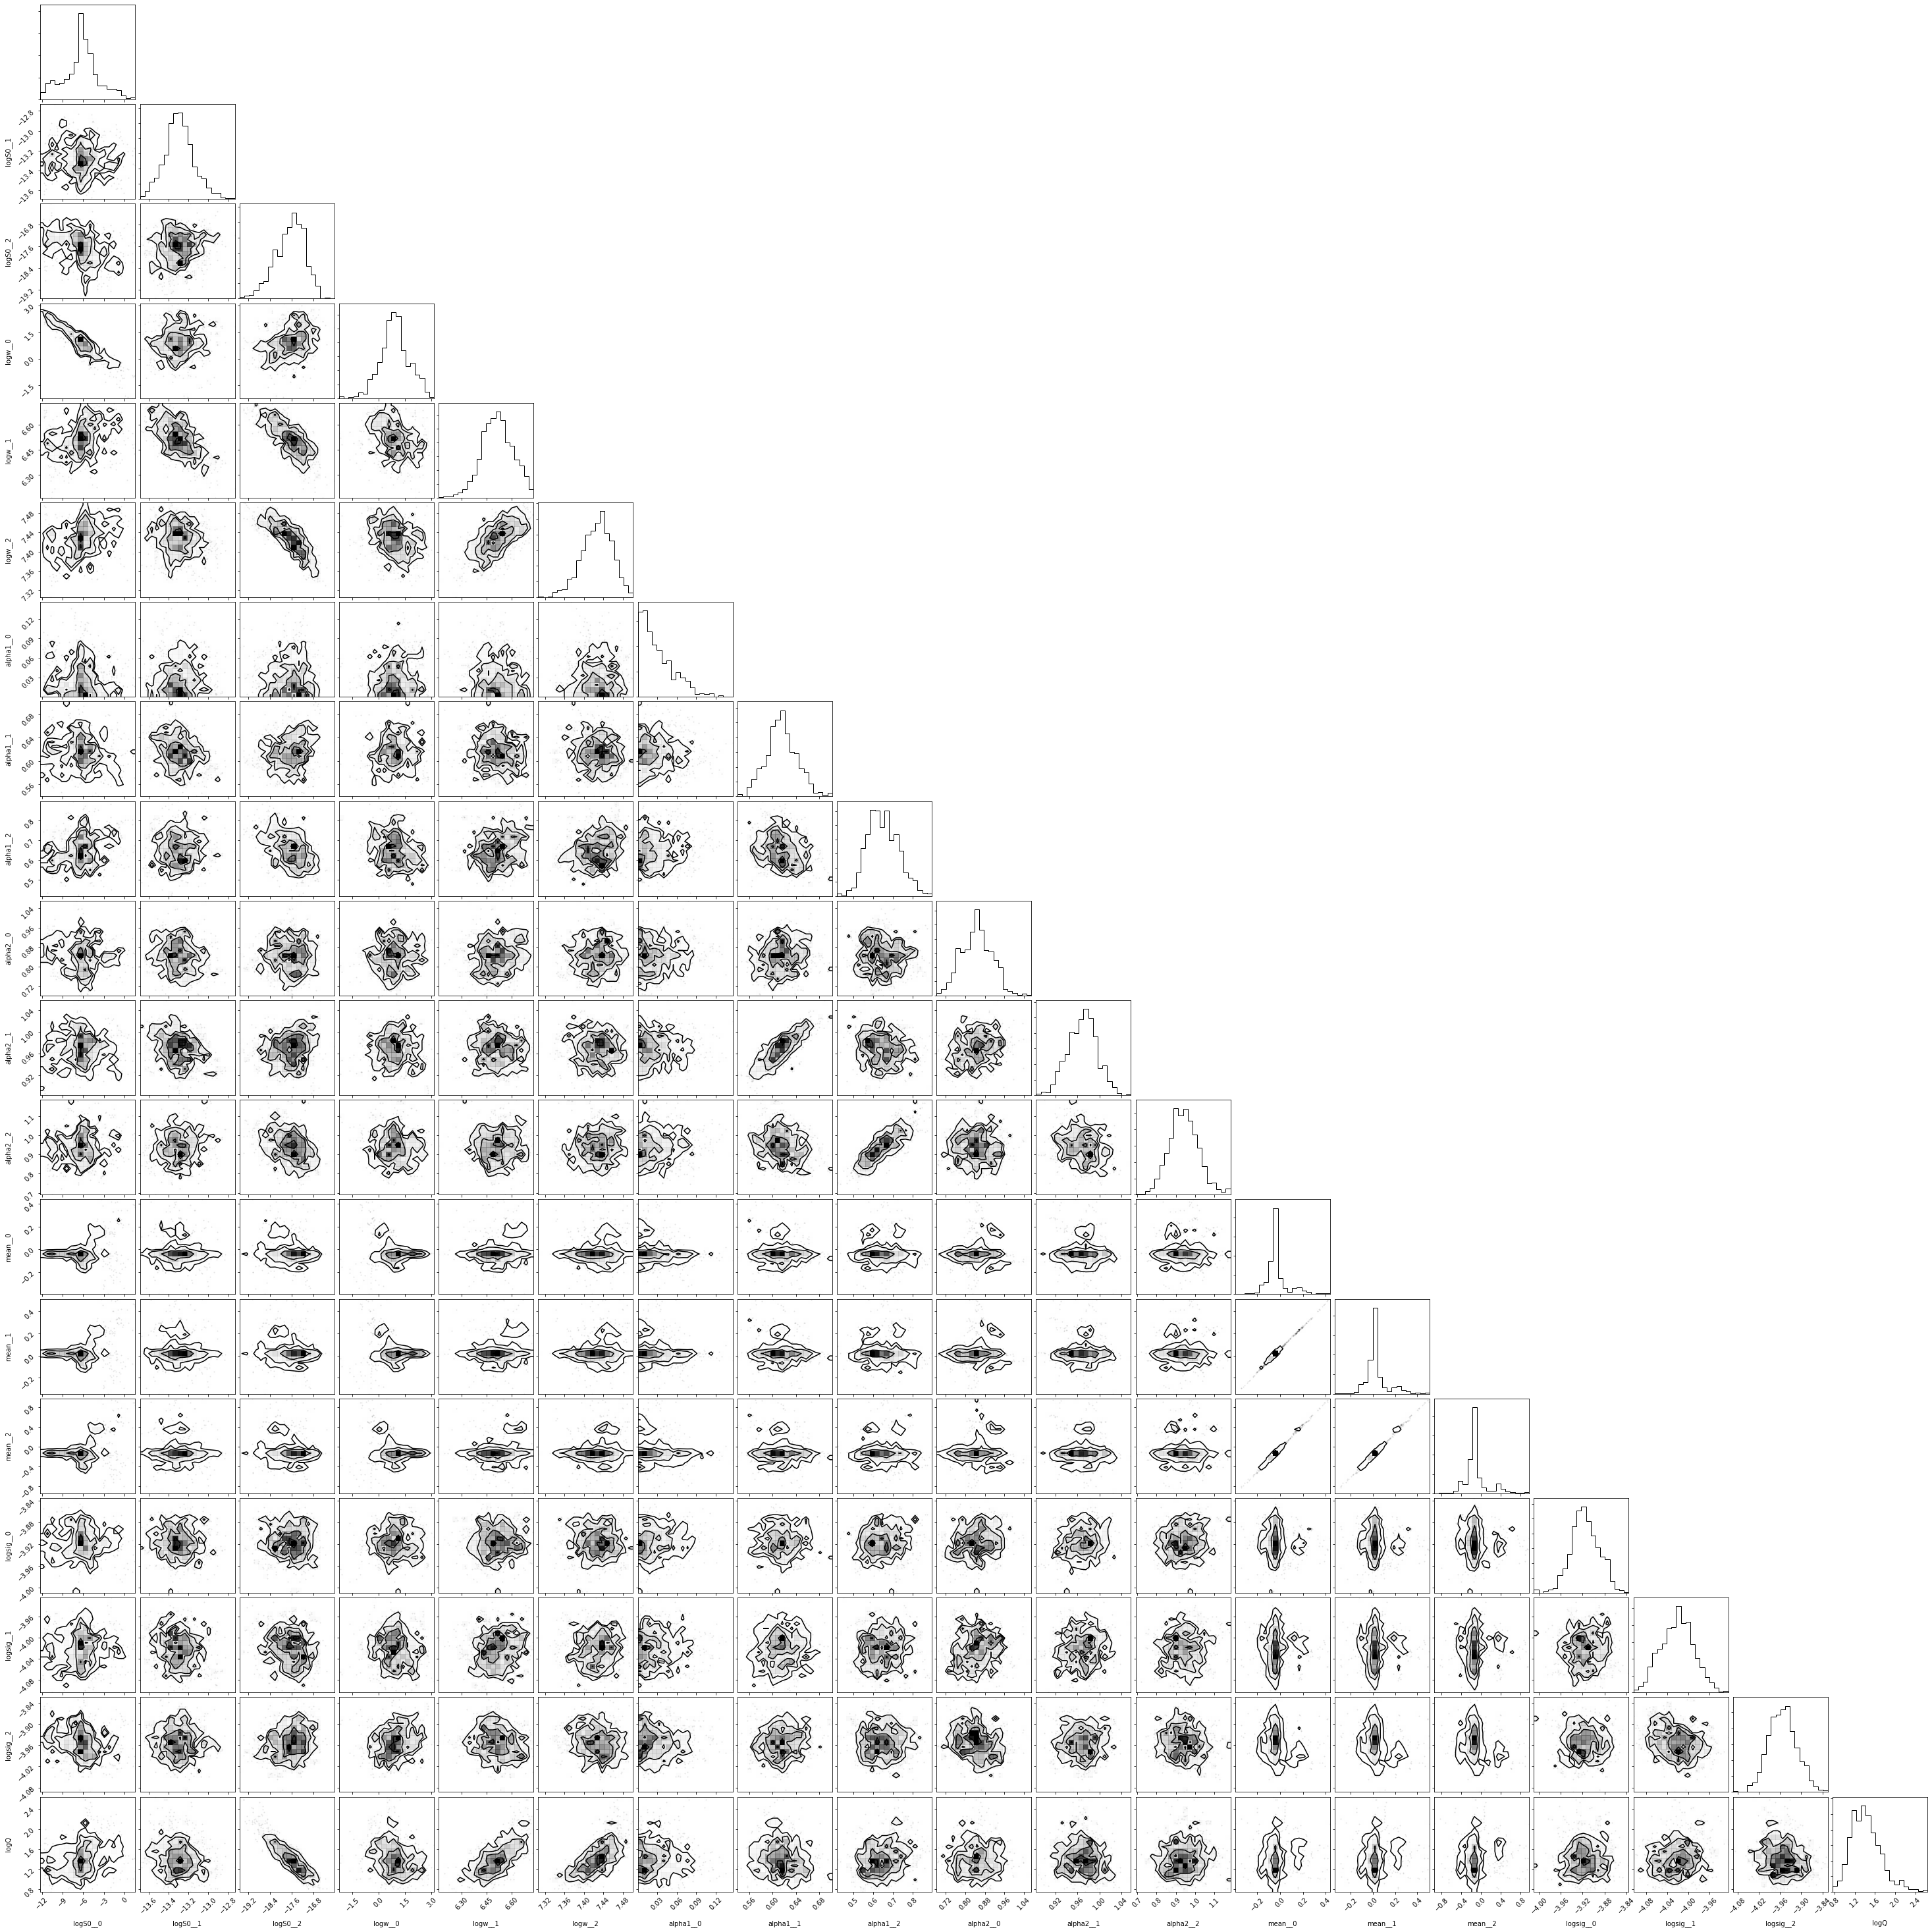

In [7]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

We can also take a closer look at a random subset of samples from the MCMC chains:

Text(0.025, 0.4, 'power (ppm$^2$/Hz)')

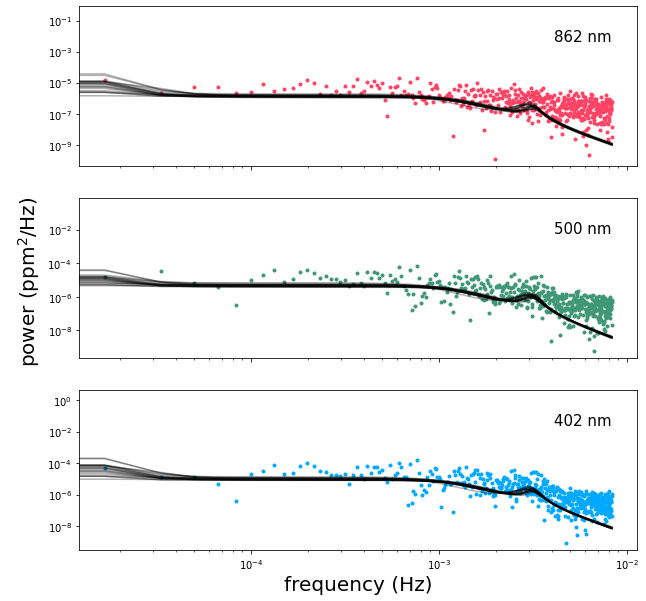

In [8]:
nsamp = 20
inds = np.random.randint(len(trace), size=nsamp)
with model:
    power = [xo.eval_in_model(
        kernel.psd(2*np.pi*fdays), trace[i])
        for i in inds
    ]
    
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfft[0], '.', color=colors[0])
ax[1].loglog(f, powerfft[1], '.', color=colors[1])
ax[2].loglog(f, powerfft[2], '.', color=colors[2])

for p in power:
    ax[0].loglog(f, p[:,0], color='k', alpha=0.3)
    ax[1].loglog(f, p[:,1], color='k', alpha=0.3)
    ax[2].loglog(f, p[:,2], color='k', alpha=0.3)
    
[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
ax[2].set_xlabel('frequency (Hz)', fontsize=20)
pl.annotate(r"power (ppm$^2$/Hz)", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

As you can see, the full MCMC analysis is much better at converging towards the maximum likelihood solution. 

Finally, if you prefer to look at timeseries in, well, time-space rather than frequency-space, we can plot a random realization of the GP for a random sample from the MCMC to verify that it looks like it has the same noise properties as the original SOHO data:

Text(0.025, 0.4, 'normalized flux')

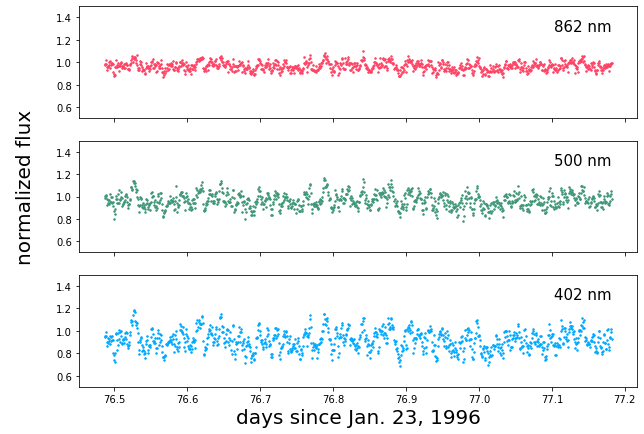

In [9]:
# random index for a random trace
i = np.random.randint(len(trace))

# an array of normally-distributed random numbers to seed 
# the GP sample
n = np.random.randn(3*len(t), 1)

with model:
    samp = xo.eval_in_model(gp.dot_l(n), trace[i])
samp_rgb = np.reshape(samp.T, (len(t), 3)).T  

fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
[a.plot(t, 1+f, '.', color=colors[i], ms=3.0) for i, (a, f) in enumerate(zip(ax, samp_rgb))]
[a.annotate(b, xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15) 
     for a, b in zip(ax, bands)]
[ax.set_ylim(0.5, 1.5) for ax in ax]

ax[2].set_xlabel('days since Jan. 23, 1996', fontsize=20)
pl.annotate("normalized flux", xy=(0.025, 0.4), 
            xycoords='figure fraction', 
            rotation=90, fontsize=20)

We end with a few warnings for anyone interested in exploring this example more on their own. As for all covariance matrices, the Kronecker-structured matrices we deal with here must be positive definite for the model to be computed. Unfortunately, positive definiteness is difficult to prove for matrices of this type. We provide a function, ``SpecGP.terms.KroneckerTerm.posdef(x, diag)`` which takes a vector of input coordinates, ``x`` and a vector of white noise variances ``diag``, and returns a boolean indicating whether the model is positive definite or not for that specific combination of parameters (those of the celerite term, the vector passed into the KroneckerTerm, and the white noise variance). This function is slow to compute, and should therefore only be used to explore the positive definiteness of specific models, rather than as a condition within a loop. 

In the code above we add white noise to the SOHO data. This is because the SOHO data is very high precision, and without the inclusion of artificial white noise the model easily slips into a part of parameter space where the covariance matrix is not positive definite. In general, a model that is not positive definite can be made so with the addition of white noise or the reduction of the correlated variability amplitude relative to the existing white noise amplitude. Our recommended procedure is to add a known quantity of white noise to the observations such that it stabilizes the model without obscuring features of interest. This should only be necessary for very high precision photometry. 